In [5]:
import numpy as np
import DDPG.DDPG as dg 
import Env.env as e
import Utils.utils as utils
import DDPG.buffer as bf
import time 
import pickle
import os
import matplotlib.pyplot as plt
# Set print options for NumPy arrays to format floating-point numbers with 5 decimal places;
# By using this line, any floating-point numbers in a NumPy array will be printed with exactly 5 decimal places.
np.set_printoptions(formatter={'float': lambda x: "{0:0.5f}".format(x)})

def plot_figure_state(figure_state, filename='./learning_curve/figure_state.png'):
    figure_state = np.array(figure_state)
    time = np.linspace(0, len(figure_state), len(figure_state))

    plt.figure()
    plt.plot(time, figure_state[:, 0], label='State 1')
    plt.plot(time, figure_state[:, 1], label='State 2')

    plt.xlabel('Time')
    plt.ylabel('State Value')
    plt.title('State Values Over Time')
    plt.legend()
    
    plt.savefig(filename)
    plt.close()  # 关闭图形以释放内存


# setting the episode length. 
episode_length = 1000 

replay_buffer_file = 'replay_buffer.pkl'

def actor_training(env, policy, batch_size, replay_buffer, start_timesteps, total_ep_training ):

    global episode_length 

    # list to store the episode rewards. 
    ep_reward_list = [] 

    # exploration  VS exploitation  Decay rate for the standard deviation of noise.
    # This controls how much the noise (exploration) decreases over time.
    # A higher decay_rate (e.g., 0.02) leads to faster decay, resulting in less exploration in later episodes,
    # while a lower decay_rate (e.g., 0.01) maintains exploration for a longer period, potentially aiding in finding a global optimum.
    decay_rate = 0.03 

    data_listt = [] 

    start = time.time() 
    # Load replay buffer data if the file exists
    '''if os.path.exists(replay_buffer_file):
        with open(replay_buffer_file, 'rb') as f:
            replay_buffer = pickle.load(f)'''
    # else:
    #     replay_buffer = ReplayBuffer()  # Initialize your replay buffer here

    for ep in range(1, total_ep_training): #total_ep_training = 3000 
        
        print("\n \n \n episode : ", ep ) 
        episode_reward = 0 
        # call the reset function to get the initial state....
        state, info_dic = env.reset() 

        # setpoint state and setpoint actions for the current episode 
        setpoint_state = info_dic['setpoint_state']   
        setpoint_action = info_dic['setpoint_action'] 

        # decay of the statndard diviation with the episode 
        decay_std = 1 * 1/(1 + decay_rate * ep)   

        std_dev = np.array([decay_std, decay_std*0.1], dtype=float)   # the larger std, the larger noise  
        ep_len = 0  

        actions__ = [] 
        obs__ = [] 
        us_obs__ = []
        us_actions__ = [] 


        break_episode = False  
        counter = 0

        figure_state=[]
        while not(break_episode): 
            counter += 1

            ep_len += 1 

            ### selecting the actions random actions for some staring some episodes...
            if ep <= start_timesteps: #start_timesteps = 1000
                action = env.action_space.sample()   
            else:

                aaa1=policy.select_action(state)
                aaa2=utils.gaussian_noise(mean=np.array([0, 0]) , std=std_dev )
                noisy_action = policy.select_action(state) + utils.gaussian_noise(mean=np.array([0, 0]) , std=std_dev )  
                                           
                action = utils.clip_negative_positive_one(noisy_action)  
                
            ### Perform action
            # print("actions : ", action) 

            obs__.append(state)  
            actions__.append(action)    

            # # print(state)
            t_s  = utils.reverse_normalize_minmax_states(state[:2]) 
            # # print(state[:2])
            # t_e  = utils.reverse_normalize_minmax_error(state[2]) 
            # # print(state[2])
            # t_ie = utils.reverse_normalize_minmax_ierror(state[3]) 
            # # print(state[3])

            # obsss = np.concatenate([t_s, t_e, t_ie]) 
            # us_obs__.append(obsss) 

            t_a = utils.reverse_normalize_minmax_actions(action)   
            # us_actions__.append(t_a)    
            
            #### calling the step function which is returning the next_state, reward, termination and trancate....
            next_state, reward, terminated, trancate, _ = env.step(action) 
            
            ### break episode if terminate or trancate is true. 
            # terminated = true: the state converges to steady state; trancate=true: length = episode length
            break_episode = terminated or trancate  
            done = terminated 

            if done:
                d = 1
            else:
                d = 0

            ### Store data in replay buffer 
            replay_buffer.add(state, action, next_state, reward, d)  

            ### Train agent after collecting sufficient data
            if ep >= start_timesteps:
                policy.train(replay_buffer, batch_size )    


            if break_episode: 
                obs__ = np.array(obs__) 
                actions__ = np.array(actions__)  


                print(" step   : ", np.round(setpoint_state, 2))  
                print(" state  : ", np.round(t_s, 2))   
                print(" step a : ", np.round(setpoint_action, 2)) 
                print(" action : ", np.round(t_a, 2))    
                print(" done   : ", done)        

                print("   _std : ", np.round(decay_std, 3))   
                print("episode length : ", counter) 


                dict__n = {
                    "setpoint_state  ": setpoint_state, 
                    "state           ":t_s,
                    "setpoint_action ": setpoint_action,
                    "action          ":t_a,
                    "ep_reward       ":episode_reward,
                    "reward          ":reward,
                    "done            ":done,
                    "std             ":decay_std, 
                    "episode length  ":counter 
                }  

                data_listt.append(dict__n) 


            if ep % episode_length == 0: 
                # dir_l = utils.global_dir + '/data'  
                # policy.save(dir_l, ep)   

                # file  = utils.global_dir + '/data/mat/reward_list'+ str(ep) +'.csv'
                # np.savetxt(file, ep_reward_list, delimiter=',')     
                pass 


            state = next_state 
            episode_reward += reward 

            
            figure_state.append(t_s)
 
        if ep>1:
            plot_figure_state(figure_state, 'figure_state_episode_{}.png'.format(ep))


        ep_reward_list.append(episode_reward)    
        print("\nEpisode reward : ", round(episode_reward, 2))  
        
        if ep == 1000: 
            # Save replay buffer data to file at the end of the run
            with open(replay_buffer_file, 'wb') as f:
                pickle.dump(replay_buffer, f)


    end = time.time() 

    time_taken_in_seconds = round(end-start, 2)  
    time_taken_in_minutes = round(time_taken_in_seconds / 60, 2) 
    time_taken_in_hours  = round(time_taken_in_minutes / 60, 2) 


    # saving the time taken to train the Actor agent. 
    with open('time.txt', 'w') as file:
        file.write(str(start))  
        file.write('\n') 
        file.write(str(end))  
        file.write("\n"+str(time_taken_in_seconds)+" time taken during training in seconds")      
        file.write("\n"+str(time_taken_in_minutes)+" time taken during training in minutes")     
        file.write("\n"+str(time_taken_in_hours)+" time taken during training in hours")     

    print() 

    file  = utils.global_dir + '/data/mat/reward_list.csv'
    np.savetxt(file, ep_reward_list, delimiter=',')  

    dir_l = utils.global_dir + '/data'
    policy.save(dir_l, 17) 


    with open('output_list.txt', 'w') as file:
        for dictionary in data_listt:
            for key, value in dictionary.items():
                file.write('%s:%s\n' % (key, value))
            file.write('\n')

In [ ]:
## creating the environment. 
    cstr = e.cstr_env() 

    state_dim_ = cstr.observation_space.shape[0] 
    action_dim_ = cstr.action_space.shape[0]  

    print("state dim : ", state_dim_) 
    print("action dim : ", action_dim_ )   
    
    # create the DDPG object. 
    ddpg = dg.DDPG( 
            state_dim=state_dim_, 
            action_dim=action_dim_, 
            discount=1, 
            tau=0.001
        )    

    ## buffer size 
    buffer_size = int(1e6)  

    # creating the buffer which is used to save the tranistions [s, a, s', r, done]
    buffer = bf.ReplayBuffer(state_dim_, action_dim_, buffer_size)  

    actor_training( 
        env= cstr,
        policy= ddpg,
        # batch size used to update the actor-critic.
        batch_size= 256,
        replay_buffer= buffer,
        # warm-up episodes till episode_length episodes there is no update in the actor-critic network. 
        start_timesteps=  1000, #episode_length,
        # totoal number of episodes used to train the actor-critic network.
        total_ep_training = 3000 
    )

In [3]:
len(ddpg.actor_loss_list)

353977

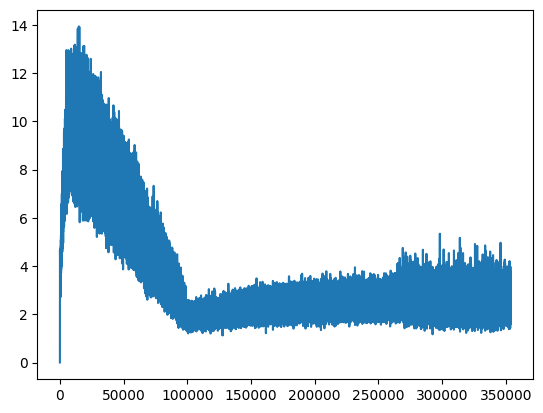

In [4]:
plt.plot(np.arange(0, 353977), ddpg.actor_loss_list)

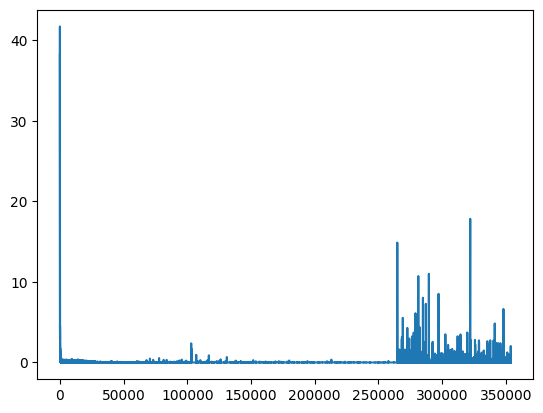

In [6]:
plt.plot(np.arange(0, 353978), ddpg.critic_loss_list)

In [19]:
## second-order cstr example
    ## creating the environment. 
    cstr = e.cstr_env() 

    state_dim_ = cstr.observation_space.shape[0] 
    action_dim_ = cstr.action_space.shape[0]  

    print("state dim : ", state_dim_) 
    print("action dim : ", action_dim_ )   
    
    # create the DDPG object. 
    ddpg = dg.DDPG( 
            state_dim=state_dim_, 
            action_dim=action_dim_, 
            discount=1, 
            tau=0.001
        )    

    ## buffer size 
    buffer_size = int(1e6)  

    # creating the buffer which is used to save the tranistions [s, a, s', r, done]
    buffer = bf.ReplayBuffer(state_dim_, action_dim_, buffer_size)  

    actor_training( 
        env= cstr,
        policy= ddpg,
        # batch size used to update the actor-critic.
        batch_size= 256,
        replay_buffer= buffer,
        # warm-up episodes till episode_length episodes there is no update in the actor-critic network. 
        start_timesteps=  1000, #episode_length,
        # totoal number of episodes used to train the actor-critic network.
        total_ep_training = 3000 
    )

state dim :  4
action dim :  2

 
 
 episode :  1
 step   :  [0.00000 0.00000]
 state  :  [0.85000 0.07000]
 step a :  [0.00000 0.00000]
 action :  [-12.64000 -0.27000]
 done   :  False
   _std :  0.971
episode length :  1000

Episode reward :  -3971.4

 
 
 episode :  2
 step   :  [0.00000 0.00000]
 state  :  [0.44000 0.03000]
 step a :  [0.00000 0.00000]
 action :  [13.26000 -0.74000]
 done   :  False
   _std :  0.943
episode length :  1000

Episode reward :  -4114.33

 
 
 episode :  3
 step   :  [0.00000 0.00000]
 state  :  [-0.64000 -0.09000]
 step a :  [0.00000 0.00000]
 action :  [16.08000 -0.42000]
 done   :  False
   _std :  0.917
episode length :  1000

Episode reward :  -2886.76

 
 
 episode :  4
 step   :  [0.00000 0.00000]
 state  :  [-0.32000 -0.08000]
 step a :  [0.00000 0.00000]
 action :  [6.93000 -0.53000]
 done   :  False
   _std :  0.893
episode length :  1000

Episode reward :  -3642.07

 
 
 episode :  5
 step   :  [0.00000 0.00000]
 state  :  [-0.47000 0.04000]


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\zhuxinji\\Desktop\\zhuxinji\\actor-critic\\DDPG\\2_Federated RL_home/data/mat/reward_list.csv'

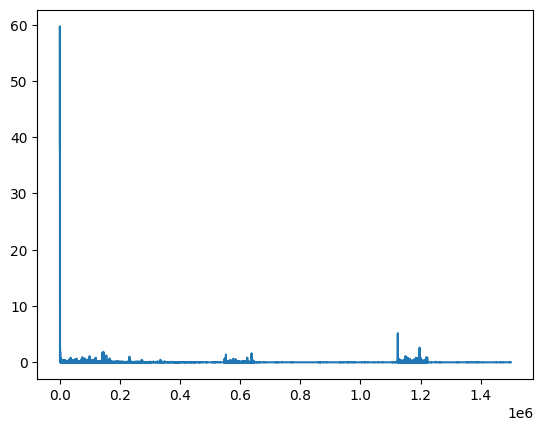

In [30]:
plt.plot(np.arange[0:1500000], ddpg.critic_loss_list)

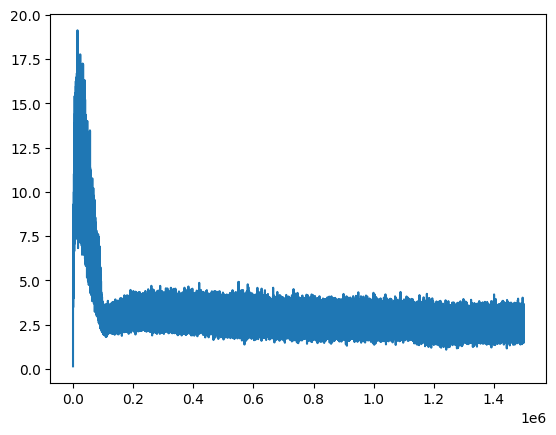

In [28]:
plt.plot(np.arange[:1500000], ddpg.actor_loss_list)